In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os

Ejercicio 2: Delfines

In [4]:
# Leemos el archivo
myFolder=(os.getcwd()+'/tc01_data/') #busca en el directorio actual

# Primero creamos la red de delfines. Agregando los enlaces se agregan automaticamente los nodos
mydolphins = nx.read_gml(myFolder+'new_dolphins.gml')

# Ahora creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv(myFolder+'dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)
    

#print mydolphins.nodes['Jet']['gender'] Para ver la prop genero en el delfin 'Jet'


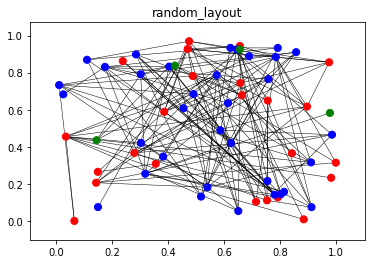

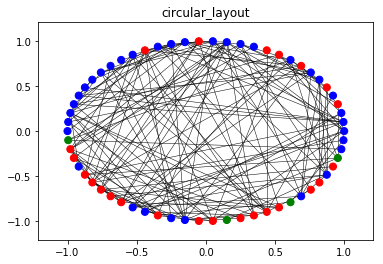

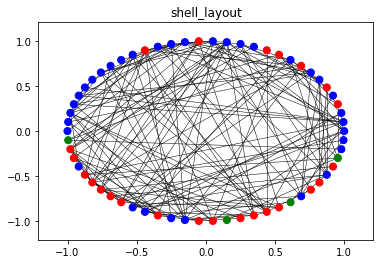

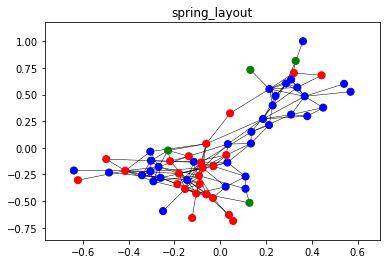

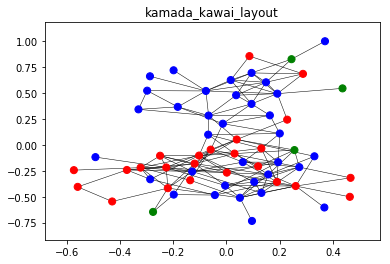

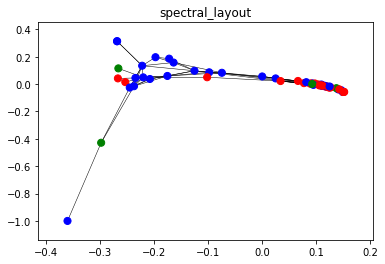

In [6]:
#a) Tipos de Layout

layouts=['random_layout','circular_layout','shell_layout','spring_layout','kamada_kawai_layout','spectral_layout']
# fruchterman reingold es el algoritmo que usa spring

for f,lay in enumerate(layouts):
 plt.figure(f)
 nx.draw_networkx(mydolphins,eval('nx.'+lay)(mydolphins),
        width=.5,
        node_color=["blue" if g=="m" else "red" if g=="f" else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()], 
        node_size=50,
        with_labels=False
       )
 plt.title(lay)
plt.show()



In [7]:
#b)Analisis de la homofilia
Enlaces_fm=[]

#Hacemos 3000 asignaciones aleatorias de genero:
num_asignaciones=3000
for it in range(0,num_asignaciones):

    #Reordenamos el vector de generos
    if it==0:
        genero_shuffle=genero #No lo reordenamos si es el primero de la red real
    else:
        genero_shuffle=genero
        np.random.shuffle((genero_shuffle)) #Reordenamos aleat los generos si no es el primero

    #Reasignamos a cada nodo un valor en el vector de genero_shuffle:
    for d,g in zip(delfines,genero_shuffle):
        mydolphins.add_node(d, gender=g)
        
    #Contamos la fraccion de enlaces que conecta nodos con diferente genero o sea f-m:
    enlaces=list(mydolphins.edges.data())
    enlaces_fm=0 #Ponemos en cero el contador
    #Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
    for i in range(0,len(enlaces)-1):
        genero1=mydolphins.nodes[enlaces[i][0]]['gender']
        genero2=mydolphins.nodes[enlaces[i][1]]['gender']
        if genero1 != genero2:   #Comparamos los generos
            enlaces_fm += 1 #Incrementamos el contador si el enlace es f-m
    Enlaces_fm.append(enlaces_fm) #Guardamos la cantidad de enlaces f-m

#Valor medio y desviacion standar
mean_enlacesfm=np.mean(Enlaces_fm)
desv_enlacesfm=np.std(Enlaces_fm)

#b)ii) Comparación

print ('Distribucion de enlaces fm:')
print ('Valor medio(H null): {}'.format(mean_enlacesfm))
print ('Desviacion Standar: {}'.format(desv_enlacesfm))
print ('Valor de Red Real: {}'.format(Enlaces_fm[0]))
  



Distribucion de enlaces fm:
Valor medio(H null): 88.08133333333333
Desviacion Standar: 6.255614935577655
Valor de Red Real: 63


p valor: 1.0


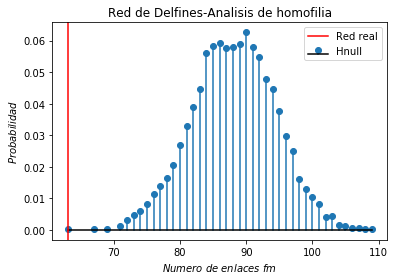

In [8]:
#b)iii) Histograma y p-valor:
histograma=np.unique(Enlaces_fm,return_counts=True)
k_enlacesfm=histograma[0]
probabilidad=histograma[1]/float(num_asignaciones)

#p-valor: supongamos que sea la probabilidad que queda acumulada a la derecha del valor que obtuvimos del numero de enlaces_fm de la red real.
#Buscamos el k_enlacesfm mas cercano al que nos dio la red real.
closestto=Enlaces_fm[0]
theclosest=min(histograma[0], key=lambda x:abs(x-closestto))
theclosest_index=int(np.where(histograma[0] == theclosest)[0])

#Sumamos las probabilidades desde el mas cercano hasta el ultimo hacia la derecha.
pvalue=np.sum(probabilidad[theclosest_index :])
print ('p valor: {}'.format(pvalue))


plt.figure()
plt.stem(k_enlacesfm,probabilidad, basefmt='k', label='Hnull')
plt.axvline(Enlaces_fm[0], c="red",label='Red real')#Linea vertical en el valor de la red real
plt.xlabel('$Numero$ $de$ $enlaces$ $fm$')
plt.ylabel('$Probabilidad$')
plt.title('Red de Delfines-Analisis de homofilia')
plt.legend()
plt.show() 


Ir eliminando los de menor clustering (que son los que tienen menos vecinos conectados)
Hacer grafico de componente gigante en funcion de nodos eliminados
Comparar con lo mismo pero eliminando segun k (que seria la forma mas facil)

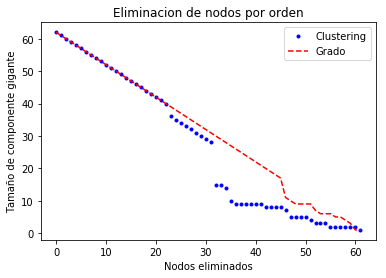

In [84]:
dolphins_copy = nx.read_gml(myFolder+'new_dolphins.gml')
dolphins_copy2 = nx.read_gml(myFolder+'new_dolphins.gml')

# Diccionarios con los coeficientes de clustering y el grado correspondientes a cada delfin
coef = nx.clustering(dolphins_copy)
grado = dict(dolphins_copy2.degree())

# Lista de delfines ordenada por coef de clustering de menor a mayor, y por grado
C_orden=sorted(coef, key=coef.__getitem__)
G_orden=sorted(grado, key=grado.__getitem__)

# L=sorted(coef.items(), key=lambda x: x[1]) #si quiero que aparezca tambien el C


# Para hacer un grafico de tamaño de componente gigante en funcion de nodos eliminados
L = len(dolphins_copy) # tamaño del grafo (cantidad de nodos)
nodos_elim = np.arange(L) # vector que va del 0 al L-1, cantidad de nodos que se va a ir eliminando
comp_size_C = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_C[0] = L # la primera componente es el tamaño del grafo

comp_size_G = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_G[0] = L # la primera componente es el tamaño del grafo


# si quisieramos frenar apenas se separa la componente gigante
# nx.is_connected(dolphins_copy)

# no uso enumerate porque sino elimina hasta el ultimo nodo
for i in range(L-1):
    dolphins_copy.remove_node(C_orden[i])
    comp_size_C[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))

for i in range(L-1):
    dolphins_copy2.remove_node(G_orden[i])
    comp_size_G[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy2),key=len))

plt.plot(nodos_elim,comp_size_C,'.b',label='Clustering')
plt.plot(nodos_elim,comp_size_G,'--r',label='Grado')
plt.xlabel('Nodos eliminados')
plt.ylabel('Tamaño de componente gigante')
plt.title('Eliminacion de nodos por orden')
plt.legend()
plt.show() 



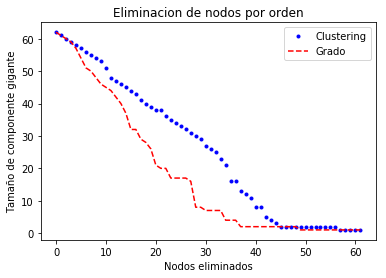

In [85]:
# Pruebo lo mismo pero ordenando al revés

dolphins_copy = nx.read_gml(myFolder+'new_dolphins.gml')
dolphins_copy2 = nx.read_gml(myFolder+'new_dolphins.gml')

# Diccionarios con los coeficientes de clustering y el grado correspondientes a cada delfin
coef = nx.clustering(dolphins_copy)
grado = dict(dolphins_copy2.degree())

# Lista de delfines ordenada por coef de clustering de menor a mayor, y por grado
C_orden=sorted(coef, key=coef.__getitem__,reverse=True)
G_orden=sorted(grado, key=grado.__getitem__,reverse=True)

# L=sorted(coef.items(), key=lambda x: x[1]) #si quiero que aparezca tambien el C


# Para hacer un grafico de tamaño de componente gigante en funcion de nodos eliminados
L = len(dolphins_copy) # tamaño del grafo (cantidad de nodos)
nodos_elim = np.arange(L) # vector que va del 0 al L-1, cantidad de nodos que se va a ir eliminando
comp_size_C = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_C[0] = L # la primera componente es el tamaño del grafo

comp_size_G = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_G[0] = L # la primera componente es el tamaño del grafo


# si quisieramos frenar apenas se separa la componente gigante
# nx.is_connected(dolphins_copy)

# no uso enumerate porque sino elimina hasta el ultimo nodo
for i in range(L-1):
    dolphins_copy.remove_node(C_orden[i])
    comp_size_C[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))

for i in range(L-1):
    dolphins_copy2.remove_node(G_orden[i])
    comp_size_G[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy2),key=len))

plt.plot(nodos_elim,comp_size_C,'.b',label='Clustering')
plt.plot(nodos_elim,comp_size_G,'--r',label='Grado')
plt.xlabel('Nodos eliminados')
plt.ylabel('Tamaño de componente gigante')
plt.title('Eliminacion de nodos por orden reverso')
plt.legend()
plt.show() 
